## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import fsolve
from astropy.io import fits
# import fitsio

%matplotlib inline

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

In [2]:
# Gauss-Hermite quadrature points and weights
gausshermite_xi_deg25, gausshermite_wi_deg25 = np.polynomial.hermite.hermgauss(25)

## Target Mean Flux and P1d

Mean Flux from Turner et al. (2024): https://arxiv.org/html/2405.06743v2

$$ \tau(z) = \tau_0 (1+z)^{\gamma} $$

where, 

$ \tau_0 = (2.46 \pm 0.14)*10^{-3} $ and $ \gamma = 3.62 \pm 0.04 $.

And mean flux is, $\bar{F}(z) = e^{\tau(z)}$

In [3]:
# Mean flux from Turner et al. (2024)

def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

DESI EDR parameters, PD13 pivot points (k,z), and fiducial / target P1D are defined at: 
https://github.com/p-slash/qsotools/blob/c58549f41fb2bd56a59c4b4362d8b331334ce13a/py/qsotools/fiducial.py#L42

And PD 13 reffers to: https://arxiv.org/abs/1306.5896

In [4]:
# DESI EDR Parameters (source?)

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009
PD13_PIVOT_Z = 3.0
    

Baseline power spectrum estimate modifies fitting function from PD13, with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top:PD13 BOSS likelihood fitting parameters. Bottom: Karacaylı et al. 2020

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
| ---|---|  ---     |---|---      |---          |
| 0.06 |-2.55|  -.010     |3.55|-0.28      | -  |
| 0.066|-2.685|  -0.22     |3.59|-0.18      |0.53|

In [5]:
# Define target P1D
# note: lmd = k1, PD13_PIVOT_K = k0, PD13_PIVOT_Z = z0

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10

    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)

    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)

    return result
    

## Define Lognormal Transformations 

$$D^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.82$

In [6]:
def D2_z(zp, nu=2.82, z0=3.0):
    return np.power((1. + zp) / (1.+z0), -nu)

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [7]:
def t_of_z(zp, tau0=0.55, tau1=5.1, z0=3.):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

$$ x(z) = \tau(z) * \exp[-D^2(z) * \sigma^2] $$

$$ x(z) = \tau_0 \left(\frac{1+z}{1+z_0} \right)^{\tau_1} * \exp \left[ - \left( \frac{1+z}{1+z_0} \right) ^{-\nu} * \sigma^2 \right] $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [8]:
def x_of_z(zp, tau0, tau1, nu, sigma2, z0=3):
    return t_of_z(zp, tau0, tau1, z0) * np.exp(-D2_z(zp, nu, z0) * sigma2)

$$ F_d(z) = e^{-\tau(z)} $$

$$ F_d(z) = \exp \left[ -x(z) * \exp [ 2 * a_z * \sqrt{2 \sigma^2} * \delta_g ] \right] $$

In [9]:
def Flux_d_z(delta_g, z, tau0, tau1, nu, sigma2, z0=3):
    e1 = np.exp(2 * D2_z(z, nu / 2, z0) * np.sqrt(2 * sigma2) * delta_g)
    e2 = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    return np.exp(-e2 * e1)

$$ \bar{F}_d(z) = \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} F_d(z) d\delta $$

(check normalization ~ e^-delta etc.)

In [10]:
def lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0=3):
    XIXI, ZZ = np.meshgrid(gausshermite_xi_deg25, z)

    Y = Flux_d_z(XIXI, ZZ, tau0, tau1, nu, sigma2, z0)
    result = np.dot(Y, gausshermite_wi_deg25)

    return result / np.sqrt(np.pi)

Input Gaussian Power: 

$$ P(k) = \frac{\exp [ n * q_0 - \alpha q_0^2 ]}{1 + (k/k_1)^{\gamma}} * \exp \left[ -\frac{(k/0.2)^2}{2} \right] $$

where, $q_0 = \ln \left(\frac{k}{0.001}+10^{-15}\right)$, $n = 0.5$, $\gamma = 1.8$, $k_1 = 0..04$

In [11]:
def lognGeneratingPower(k, n=0.5, alpha=0.26, gamma=1.8, k1=0.04):
    q0 = np.log(k / 0.001 + 1e-15)
    return np.exp(n * q0 - alpha * q0**2) / (1. + (k / k1)**gamma) * np.exp(-(k / 0.2)**2 / 2)

# Fitting for Mean Flux

Fit for mean flux example: 

In [12]:
# create redshift array
z_array = np.linspace(1.8, 5.0, 500)

# choose precision
precision = 1e-5

In [13]:
# def model and error / precision
F_turner = turner24_mf(z_array)
Err_turner = F_turner * precision + 1e-8

Define a cost funciton: 

$$ d = \frac{\bar{Flux}_{model}-\bar{Flux}_{measured}}{Error_{model}} $$

and, $cost = d \cdot d$ 

In [14]:
# def cost function 
def cost(tau0, tau1, nu, sigma2):
    d = (F_turner - lognMeanFluxGH(z_array, tau0, tau1, nu, sigma2, z0=3)) / Err_turner
    return d.dot(d)

# Set initial guesses for fitting parameters
tau0, tau1, nu, sigma2 = 0.55, 5.1, 2.82, 1.0


# minimizer: minimizes cost and determines best fit values for parameters
mini = Minuit(cost, tau0, tau1, nu, sigma2)
mini.errordef = Minuit.LEAST_SQUARES
mini.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.659e+05                  │              Nfcn = 376              │
│ EDM = 2.08e-08 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0   │ 673.77e-3 │  0.06e-3  │            │            │         │         │       │
│ 1 │ tau1   │  5.31008  │  0.00016  │            │            │         │         │       │
│ 2 │ nu     │  2.16175  │  0.00017  │            │            │         │         │       │
│ 3 │ sigma2 │  1.50381  │  0.00014  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      tau0      tau1        nu    sigma2 │
├────────┼─────────────────────────────────────────┤
│   tau0 │  3.64e-09     -6e-9      8e-9      9e-9 │
│   tau1 │     -6e-9  2.61e-08 -0.027e-6 -0.015e-6 │
│     nu │      8e-9 -0.027e-6  2.91e-08  0.019e-6 │
│ sigma2 │      9e-9 -0.015e-6  0.019e-6  2.01e-08 │
└────────┴─────────────────────────────────────────┘

In [15]:
673.77e-3

0.67377

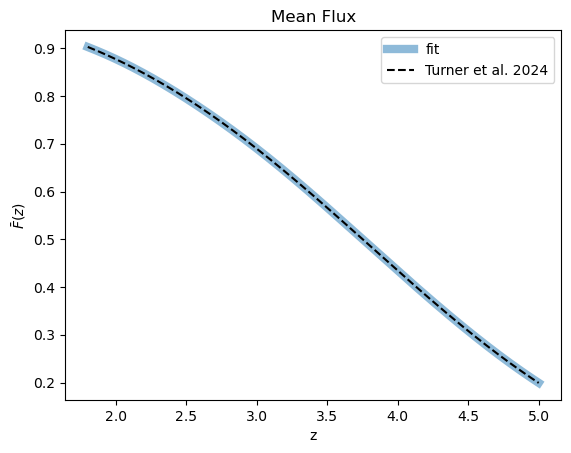

In [16]:
plt.plot(z_array, lognMeanFluxGH(z_array, *mini.values), color='tab:blue', ls='-', label='fit', lw='6', alpha = 0.5)
plt.plot(z_array, F_turner, color='black', ls='--', label='Turner et al. 2024')
plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()

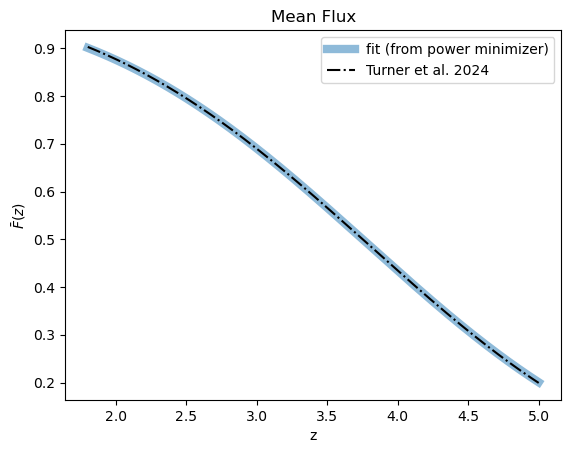

In [17]:
# Best Fit Tau0: 0.38361017450395224
# Best Fit Tau1: 4.599362884319737
# Best Fit Nu: 1.7012552066724722
# bsetfit sigma (from pgauss): 0.3908

plt.plot(z_array, lognMeanFluxGH(z_array, 0.3836, 4.599, 1.7016, 0.3908), color='tab:blue', ls='-', label='fit (from power minimizer)', lw='6', alpha=0.5)
plt.plot(z_array, F_turner, color='black', ls='-.', label='Turner et al. 2024')
plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()

In [18]:
# # Sanity Check

# tau_0_test = 673.77e-3
# tau_1_test = 5.31008
# nu_test = 2.16175	
# sigma2_test = 1.50381

# plt.plot(z_array, lognMeanFluxGH(z_array, tau_0_test, tau_1_test, nu_test, sigma2_test))

# Fit for Correlation Function

### get correlation function ($\xi_G$) from P1D estimates


$$\Delta v = 1 km/s, 10 km/s, ... etc.$$

$$k_{nyq} = \frac{1}{2*\Delta v} $$

e.g., if $\Delta v = 1 km/s$, then $k_{nyq} = 0.5 km/s^{-1}$, meaning that this is the highest freqyency that can be accurately represented in a sampled dataset without aliasing effects. 

The spacing of $\Delta v$ determines how fine the velocity grid is sampled, which directly impacts the highest frequency that can be represented before aliasing occurs. 

The number of points, however, affects the total range of the velocity grid, but not the highest frequency that can be resolved. 

e.g., if you increase dv (sample coarser), $k_{nyq}$ decreases, meaning lower frequencies can be resolved before aliasing. But if you decrease dv (sample more finely), $k_{nyq}$ increases, meaning you can resolve *higher* frequencies. 

$$\Delta k = \frac{2 \pi}{L} = \frac{2 \pi}{N * \Delta v}$$

We need $\Delta k ~ 10e-6$ (i.e. 10^-5), so we need to adjust N points and $\Delta v$ velocity spacing accordingly.

e.g. if we set dv = 1 km/s, and work backwards, we can raarrange for N: 

$$ N = \frac{2 \pi}{\Delta k * \Delta v} $$

such that for $\Delta v = 1 km/s$, we get N = 628318 (in k-space). Then, relating back to v-space by the definition of k_arr: 

$$ numvpoints = \frac{N}{2} = \frac{628318}{2} = 314159 $$

Then checking the nyquist frequencey condition: 

$$ k_{nyq} = \frac{1}{2 \Delta v} = \frac{1}{2 * 1 km/s} = 0.5 (km/s)^{-1} $$



(thus we need numvpoints in v-space ~ 2^19)

In [19]:
num_str = "10e-6"
num_formatted = np.format_float_positional(float(num_str), trim="-")
print(num_formatted)

0.00001


In [20]:
num_str = "1.1984224905356572e-05"
num_formatted = np.format_float_positional(float(num_str), trim="-")
print(num_formatted)

0.000011984224905356572


In [77]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')

# create velocity array 
numvpoints = 2**13
# numvpoints = 2**10
dv = 0.4  # (km/s)         
v_array = np.arange(numvpoints) * dv
print('Number of v-points: '+ str(numvpoints))

# k-mode array
k_arr  = 2. * np.pi * np.fft.rfftfreq(2 * numvpoints, d=dv) + 1e-12 

# z_p1d_arr = np.arange(13) * 0.2 + 2.0
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])

# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

Number of v-points: 8192


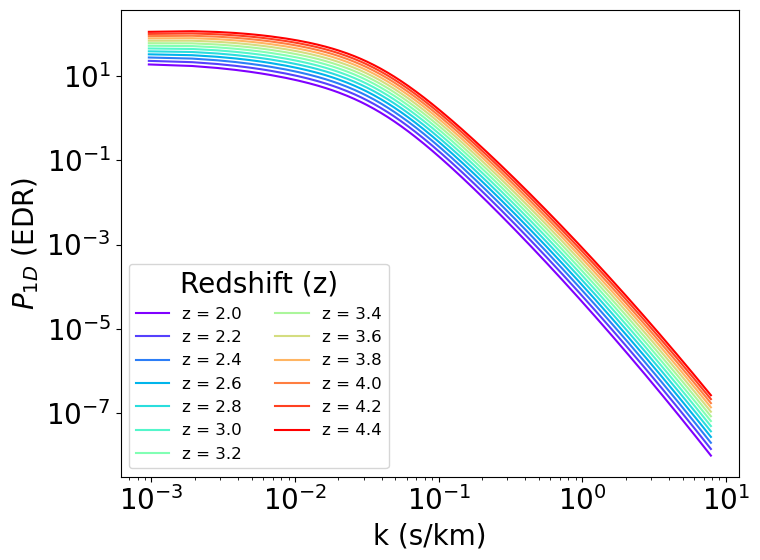

In [78]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

for z, xi in zip(zlist, p1d_edr_fit):
    color = cmap(norm(z))                                               # Get the corresponding color from the colormap
    plt.loglog(k_arr[1:], xi[1:], label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='lower left', ncol=2, title="Redshift (z)", fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ (EDR)')
plt.tight_layout()
plt.show()

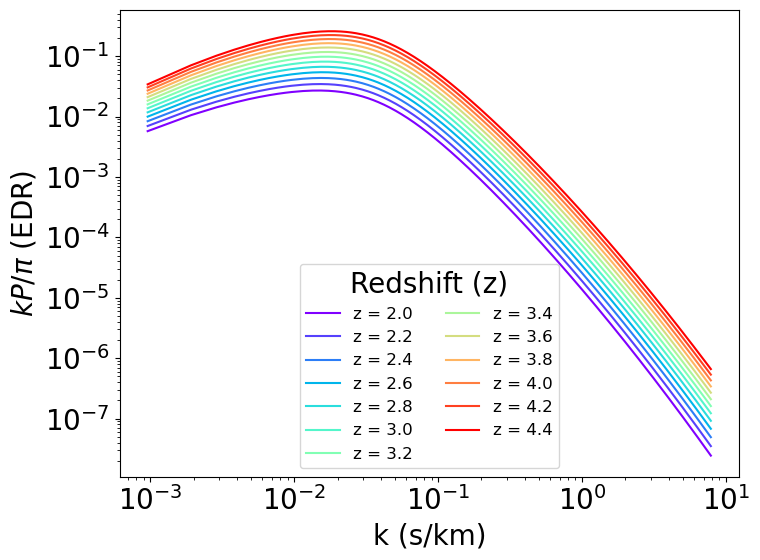

In [79]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

for z, xi in zip(zlist, p1d_edr_fit):
    color = cmap(norm(z))                                               # Get the corresponding color from the colormap
    plt.loglog(k_arr[1:], k_arr[1:] * xi[1:] / np.pi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='lower center', ncol=2, title="Redshift (z)", fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$kP / \pi$ (EDR)')
plt.tight_layout()
plt.show()

### get correlation function ($\xi_G$) from P1D estimates

In [80]:
xif_edr_fit = np.empty((zlist.size, numvpoints)) 

for i, z in enumerate(zlist):
    xif_edr_fit[i] = (np.fft.irfft(p1d_edr_fit[i]))[:numvpoints] / dv

In [81]:
# for z, xi in zip(zlist, xif_edr_fit):
#     plt.semilogx(1 + v_array, xi, label=z)
# # plt.yscale("symlog")
#     plt.legend()

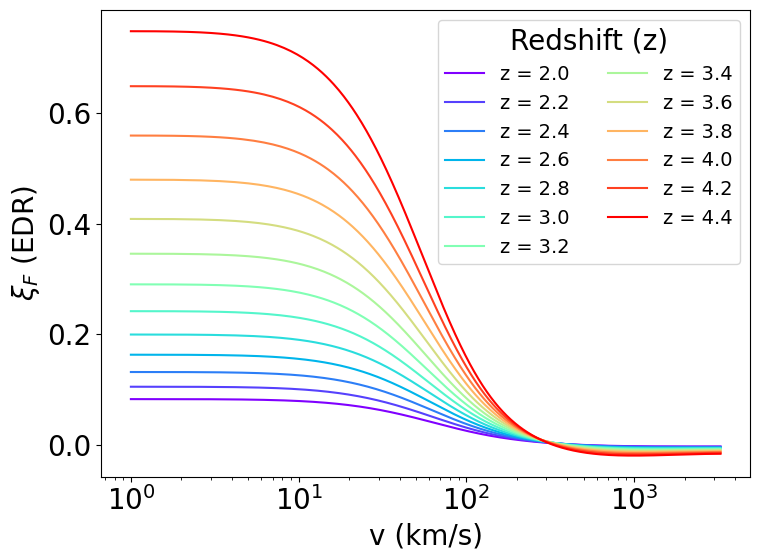

In [82]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

#################################################

# Plot the correlation function (F) for each z value
for z, xi in zip(zlist, xif_edr_fit):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plt.semilogx(1 + v_array, xi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='upper right', ncol=2, title="Redshift (z)", fontsize=14)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
# plt.title(r'$\xi_F$ EDR')
plt.tight_layout()
plt.show()
# plt.savefig('EDR_Correlation_Function')



In [83]:
# Set parameters for optimization
redshift_index = 4            # Index corresponding to z = 2.8
# z = zlist[redshift_index]   # Redshift value (2.8)
xi_f_target = xif_edr_fit[redshift_index]  
# xi_f target is just the xi_f EDR fit at a given redshift (e.g. 2.8)

print("redshift = " +str(zlist[redshift_index]))


redshift = 2.8


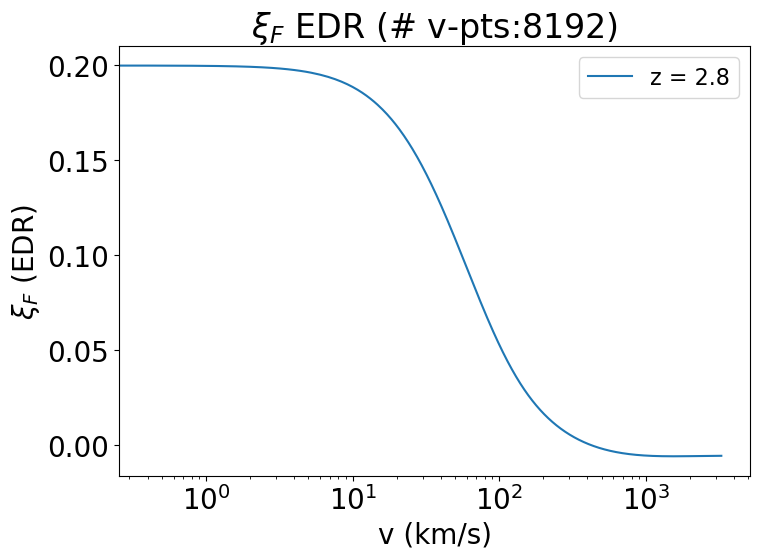

In [84]:
# locate z = 2.8 => zlist[4]
# plot only z = 2.8 for xi_F EDR data:

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(v_array, xif_edr_fit[redshift_index], label='z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ EDR (# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig('EDR_Correlation_Function_single_redshift')


now, we want to find the $\xi_G$ that gives us the correct / desired EDR $\xi_F$

In [88]:

#####################################################

# lognormal xi_f from xi_g
# goes point by point, not dealing with arrays

def lognXiFfromXiG_pointwise(z, xi_gauss, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: float
        Single xi_g value from Gaussian random field
    """
    # sigma2 = xi_gauss[0]
    sigma2 = 1.50381
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine])

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return a single xi_f scalar
    xi_f = np.sum(tempfunc) / np.pi

    return xi_f

########################################################################



In [89]:
# check that lognXiFfromXiG returns a single xi_f value for a SINGLE xi_g value
lognXiFfromXiG_pointwise(z=2.8, xi_gauss=0.1) # CHECK!

0.010486195700271556

Text(0.5, 1.0, 'target consistancy check')

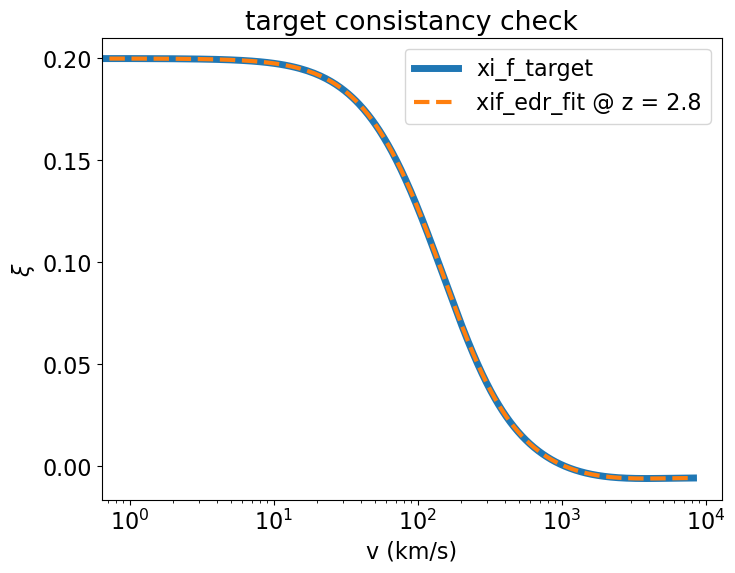

In [90]:

###################################################

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(xi_f_target, label = 'xi_f_target', lw=5)
plt.semilogx(xif_edr_fit[redshift_index], label='xif_edr_fit @ z = '+str(zlist[redshift_index]), ls = 'dashed', lw=3)
plt.legend(loc='upper right')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title('target consistancy check')

In [91]:

# # define an objective function for fsolve

# def objective(xi_g, z, xi_f_target):
#     """
#     Compute the difference between the target xi_f values and the xi_f values
#     calculated from xi_g using lognXiFfromXiG_pointwise

#     Parameters
#     ----------
#     xi_g : array-like 
#         Current guess for xi_g values.
#     z : float
#         Redshift at which xi_f is calculated.
#     xi_f_target : array-like
#         Target xi_f values, in this case, xif_edr_fit

#     Returns
#     -------
#     array-like
#         Residuals between calculated and target xi_f.
#     """
#     xi_f_calculated = np.array([lognXiFfromXiG_pointwise(z, xi_g_i) for xi_g_i in xi_g])
#     return xi_f_calculated - xi_f_target

# # Initial guess for xi_g as a 1D array matching the length of xi_f_target
# xi_g_initial_guess = np.full_like(xi_f_target, fill_value=0.0)

# # Optimize xi_g to match xi_f_target
# xi_g_optimized = fsolve(objective, xi_g_initial_guess, args=(z, xi_f_target))


In [ ]:

# Define the objective function for fsolve
def objective(xi_g, z, xi_f_target):
    """
    Compute the difference between the target xi_f values and the xi_f values
    calculated from xi_g using lognXiFfromXiG_pointwise.

    Parameters
    ----------
    xi_g : array-like
        Current guess for xi_g values.
    z : float
        Redshift at which xi_f is calculated.
    xi_f_target : array-like
        Target xi_f values, in this case, xif_edr_fit.

    Returns
    -------
    array-like
        Residuals between calculated and target xi_f.
    """
    xi_f_calculated = np.array([lognXiFfromXiG_pointwise(z, xi_g_i) for xi_g_i in xi_g])
    return xi_f_calculated - xi_f_target

# Function to generate a dynamic initial guess for xi_g
def dynamic_initial_guess(z, xi_f_target):
    """
    Generate a dynamic initial guess for xi_g based on the redshift and target xi_f values.

    Parameters
    ----------
    z : float
        Redshift at which xi_f is calculated.
    xi_f_target : array-like
        Target xi_f values.

    Returns
    -------
    array-like
        Initial guess for xi_g values.
    """
    # Example heuristic: use a proportion of xi_f_target based on redshift
    # You can adjust the proportion or use a different heuristic as needed
    initial_guess = xi_f_target * (1 + z)
    return initial_guess

# Example values for z and xi_f_target
# redshift_index = 4                # Index corresponding to z = 2.8
# redshift = zlist[redshift_index]  # z = 2.8
# xi_f_target = xif_edr_fit[redshift_index]  

# Generate the initial guess dynamically
xi_g_initial_guess = dynamic_initial_guess(zlist[redshift_index], xi_f_target)

# Optimize xi_g to match xi_f_target using the dynamic initial guess
xi_g_optimized = fsolve(objective, xi_g_initial_guess, args=(z, xi_f_target))


In [ ]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.semilogx(xi_g_optimized, color='tab:orange', label= r'$\xi_G$ fit @ z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title('(# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig('xiG_Fit')

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.rcParams.update({'font.size': 16})

# # plt.semilogx(xif_edr_fit[5], label=r'$\xi_F$ EDR @ z = '+str(zlist[redshift_index]), color='tab:blue')
# plt.semilogx(xi_f_target, label=r'$\xi_F$ EDR @ z = '+str(zlist[redshift_index]), color='tab:blue')
# plt.semilogx(xi_g_optimized, label= r'$\xi_G$ fit', color='tab:orange')
# plt.xlabel('v (km/s)')
# plt.ylabel(r'$\xi$')
# plt.title('(# v-pts:'+str(numvpoints)+')')
# plt.legend(fontsize=14)
# plt.tight_layout()

Now we need to get $\xi_F$ from $\xi_G$ optimized (uses all values, not single values now)

In [71]:
# get xi_F from xi_G optimized
# go back to working with arrays of xi_g and xi_f
def lognXiFfromXiG_array(xi_gauss, z, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: np.array(float)
        Array of xi_g values from Gaussian random field
    """
    sigma2 = xi_gauss[0]
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).T

    # Weighted vector computation
    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return xi_f array
    xi_f = np.sum(tempfunc, axis=(1, 2)) / np.pi
    return xi_f

######################################################

xi_f_optimized = lognXiFfromXiG_array(xi_gauss = xi_g_optimized, z = zlist[redshift_index],
                                tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3)

######################################################


In [72]:
# # plot xi F

# plt.figure(figsize=(8, 6))
# plt.rcParams.update({'font.size': 16})

# plt.semilogx(xif_edr_fit[redshift_index], label = r'$\xi_F$ EDR @ z = '+str(zlist[redshift_index]), color = 'tab:blue')
# # plt.semilogx(xi_f_target, label = r'$\xi_F$ EDR @ z = '+str(zlist[redshift_index]), color = 'tab:green', ls='dashed')
# plt.semilogx(xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange")

# plt.legend(fontsize=12, loc='upper right')
# plt.xlabel('v (km/s)')
# plt.ylabel(r'$\xi$')
# plt.title(r"$\xi_F$ Fit vs Data")
# txt="N  = "+str(numvpoints)+" points \n" + "dv = "+str(dv)+" km/s \n" + "dk ~ "+str(2*np.pi/(numvpoints*dv))
# plt.text(0.02, -0.3, txt, ha='left', va='center', transform=plt.gca().transAxes)
# plt.show()
# # plt.savefig('xiF_fit_vs_data')


# # print("N  = "+str(numvpoints)+" points")
# # print("dv = "+str(dv)+" km/s")
# # print("dk ~ "+str(2*np.pi/(numvpoints*dv)))

ValueError: x and y must have same first dimension, but have shapes (8192,) and (1024,)

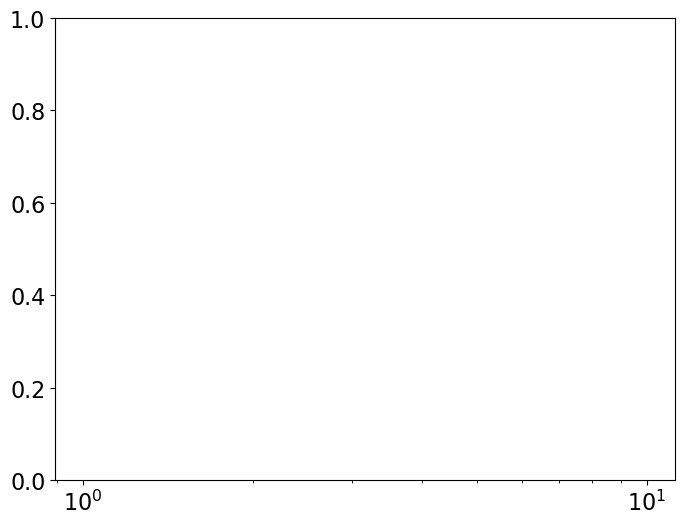

In [73]:
# plot xi F

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

##############################################

dif_xi_f = xi_f_target - xi_f_optimized
abs_dif_xi_f = np.abs(dif_xi_f)

max_y = dif_xi_f[np.argmax(abs_dif_xi_f)]  # This gives the actual value (+/-) farthest from 0
max_x = v_array[np.argmax(abs_dif_xi_f)]

##############################################

plt.semilogx(v_array, xi_f_target, label = r'$\xi_F$ Target', color = 'tab:green', ls='dashed')
plt.semilogx(v_array, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange")

plt.axhline(y=0.0, color='black', linestyle='--')
# plt.axvline(x=2* np.pi/PD13_PIVOT_K, color='red', linestyle='--', label=f"k_p: {PD13_PIVOT_K:.2E}")
plt.axvline(x=max_x, color='tab:blue', linestyle='--', label=f"max |err|: {max_x:.2E}")
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv} km/s")
plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.legend(fontsize=12)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title(r"$\xi_F$ Fit vs Data")

txt1 = "N  = "+str(numvpoints)+" points \n"
txt2 = "dv = "+str(dv)+" km/s \n"
txt3 = "dk ~ "+str(2*np.pi/(numvpoints*dv)) + '\n'
# txt4 = "k_pivot = " + str(PD13_PIVOT_K) + '(km/s)^-1 \n' 
txt5 = "|avg err| = " + str(np.abs(np.average(dif_xi_f))) + '\n'
txt6 = "max err = " + str(max_y) + " at v = " + str(max_x) + "km/s \n"
txt  =  txt1 + txt2 + txt3 + txt5 + txt6 #+ txt4 

# plt.text(0.02, -0.4, txt, ha='left', va='center', transform=plt.gca().transAxes)
plt.show()



In [74]:
# check chi2?
observed = xi_f_target
expected = xi_f_optimized

# Calculate chi2
chi2 = np.sum((observed - expected) ** 2 / expected)
print(f"Chi-squared value: {chi2}")

Chi-squared value: 0.08520054489392685


ValueError: x and y must have same first dimension, but have shapes (8192,) and (1024,)

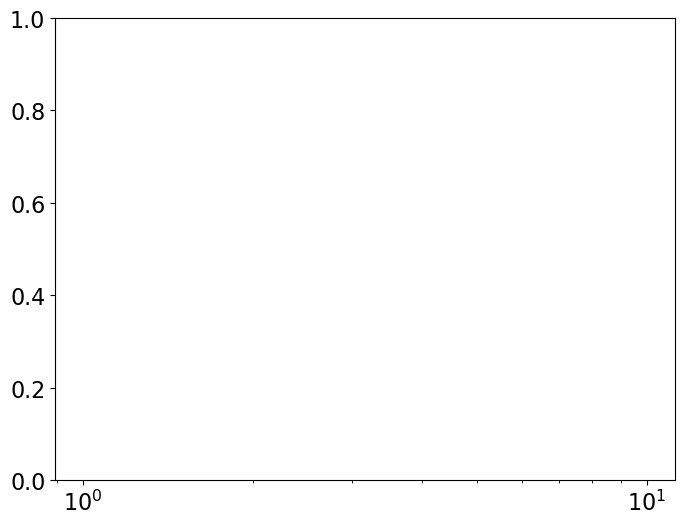

In [68]:
# plot residual 

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

##############################################

dif_xi_f = xi_f_target - xi_f_optimized
abs_dif_xi_f = np.abs(dif_xi_f)

max_y = dif_xi_f[np.argmax(abs_dif_xi_f)]  # This gives the actual value (+/-) farthest from 0
max_x = v_array[np.argmax(abs_dif_xi_f)]

##############################################

plt.semilogx(v_array, dif_xi_f, label = 'z = '+str(zlist[redshift_index]), color = 'tab:blue')
plt.axhline(y=0.0, color='black', linestyle='--')
# plt.axvline(x=2*np.pi/PD13_PIVOT_K, color='red', linestyle='--', label=f"k_p: {PD13_PIVOT_K:.2E}")
plt.axvline(x=max_x, color='tab:blue', linestyle='--', label=f"max |err|: {max_x:.2E}")
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv}")
plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\Delta \xi$')
plt.legend(fontsize=14)
plt.title(r"$\xi_F$ Residual (EDR - Fit)")

txt1 = "N  = "+str(numvpoints)+" points \n"
txt2 = "dv = "+str(dv)+" km/s \n"
txt3 = "dk ~ "+str(2*np.pi/(numvpoints*dv)) + '\n'
# txt4 = "k_pivot = " + str(PD13_PIVOT_K) + '(km/s)^-1 \n' 
txt5 = "|avg err| = " + str(np.abs(np.average(dif_xi_f))) + '\n'
txt6 = "max err = " + str(max_y) + " at v = " + str(max_x) + "km/s \n"
txt  =  txt1 + txt2 + txt3 + txt5 + txt6 #+ txt4 

plt.text(0.02, -0.4, txt, ha='left', va='center', transform=plt.gca().transAxes)
plt.show()
# plt.savefig('xiF_residual')



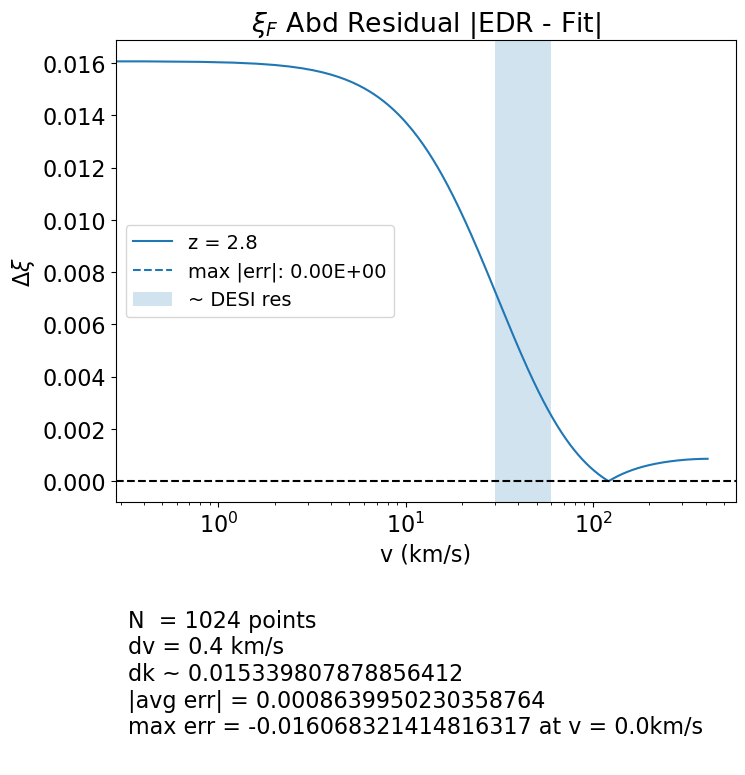

In [63]:
# plot residual 

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

##############################################

dif_xi_f = xi_f_target - xi_f_optimized
abs_dif_xi_f = np.abs(dif_xi_f)

max_y = dif_xi_f[np.argmax(abs_dif_xi_f)]  # This gives the actual value (+/-) farthest from 0
max_x = v_array[np.argmax(abs_dif_xi_f)]

##############################################

plt.semilogx(v_array, np.abs(dif_xi_f), label = 'z = '+str(zlist[redshift_index]), color = 'tab:blue')
plt.axhline(y=0.0, color='black', linestyle='--')
# plt.axvline(x=2 * np.pi/PD13_PIVOT_K, color='red', linestyle='--', label=f"k_p: {PD13_PIVOT_K:.2E}")
plt.axvline(x=max_x, color='tab:blue', linestyle='--', label=f"max |err|: {max_x:.2E}")
plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\Delta \xi$')
plt.legend(fontsize=14)
plt.title(r"$\xi_F$ Abd Residual |EDR - Fit|")

txt1 = "N  = "+str(numvpoints)+" points \n"
txt2 = "dv = "+str(dv)+" km/s \n"
txt3 = "dk ~ "+str(2*np.pi/(numvpoints*dv)) + '\n'
# txt4 = "k_pivot = " + str(PD13_PIVOT_K) + '(km/s)^-1 \n' 
txt5 = "|avg err| = " + str(np.abs(np.average(dif_xi_f))) + '\n'
txt6 = "max err = " + str(max_y) + " at v = " + str(max_x) + "km/s \n"
txt  =  txt1 + txt2 + txt3 + txt5 + txt6 #+ txt4 

plt.text(0.02, -0.4, txt, ha='left', va='center', transform=plt.gca().transAxes)
plt.show()
# plt.savefig('xiF_residual')



## Save data to .fits file

In [64]:
from astropy.io import fits

# Example data arrays
xi_f_edr = xi_f_target
xi_f_fit = xi_f_optimized
xi_g_fit = xi_g_optimized
err = dif_xi_f
abs_err = np.abs(dif_xi_f)
# chi2_data = chi2
velocity_array = v_array
redshift_array = zlist

# Create HDUs for each data array with labels
xi_f_edr_hdu = fits.ImageHDU(xi_f_edr, name='XI_F_EDR')
xi_f_fit_hdu = fits.ImageHDU(xi_f_fit, name='XI_F_FIT')
xi_g_fit_hdu = fits.ImageHDU(xi_g_fit, name='XI_G_FIT')
err_hdu = fits.ImageHDU(err, name='ERROR')
abs_err_hdu = fits.ImageHDU(abs_err, name='ABS_ERROR')
# chi2_data_hdu = fits.ImageHDU(chi2_data, name='CHI2')
velocity_array_hdu = fits.ImageHDU(velocity_array, name='VELOCITY')
redshift_array_hdu = fits.ImageHDU(redshift_array, name='REDSHIFT')

xi_f_fit_hdu.header['CHI2'] = chi2

# Create an HDUList to contain all the HDUs
hdulist = fits.HDUList([
    fits.PrimaryHDU(),  # Primary HDU (can be empty)
    xi_f_edr_hdu,
    xi_f_fit_hdu,
    xi_g_fit_hdu,
    err_hdu,
    abs_err_hdu, 
    velocity_array_hdu, 
    redshift_array_hdu
])

# Write the FITS file
hdulist.writeto('ouput_test.fits', overwrite=True)


In [65]:

# # Load the existing FITS file in update mode
# filename = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Notebooks/ouput_test.fits'
# hdulist = fits.open(filename, mode='update')

# # Create a new Image HDU for k_array
# k_array_hdu = fits.ImageHDU(k_arr, name='K_ARRAY')

# # Append the new HDU to the existing HDU list
# hdulist.append(k_array_hdu)

# # Write the changes to the file
# hdulist.flush()
# hdulist.close()


In [66]:
import fitsio

# Open the FITS file
fits = fitsio.FITS('/pscratch/sd/m/mherbold/tests/P1D_Mocks/Notebooks/ouput_test.fits')
header = fits[2].read_header()
chi2_value = header['CHI2']
print(f'Chi-squared value: {chi2_value}')

chi2_test = np.sum((fits[2][:] - fits[1][:]) ** 2 / fits[1][:])
print('chi-squared calculated: '+ str(chi2_test))

# List all extensions with their labels
print(fits)


ModuleNotFoundError: No module named 'fitsio'

## open Fitsio file and calculate power 

In [96]:
plt.semilogx(fits[6][1:], fits[1][1:], label = 'xi_f_edr')
plt.semilogx(fits[6][1:], fits[2][1:], label= 'xi_f_fit')
plt.legend(loc='upper right')

TypeError: 'module' object is not subscriptable

Text(0.5, 1.0, 'target consistancy check')

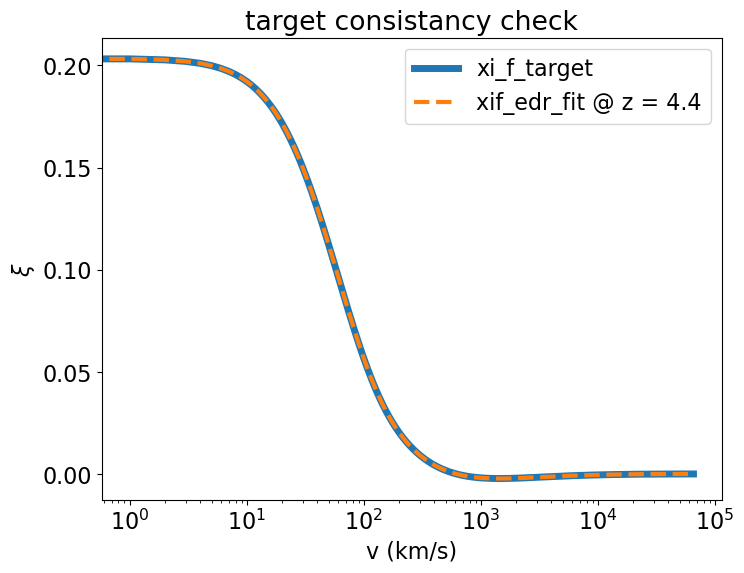

In [53]:

###################################################

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(xi_f_target, label = 'xi_f_target', lw=5)
plt.semilogx(xif_edr_fit[redshift_index], label='xif_edr_fit @ z = '+str(z), ls = 'dashed', lw=3)
plt.legend(loc='upper right')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title('target consistancy check')

(1e-05, 100.0)

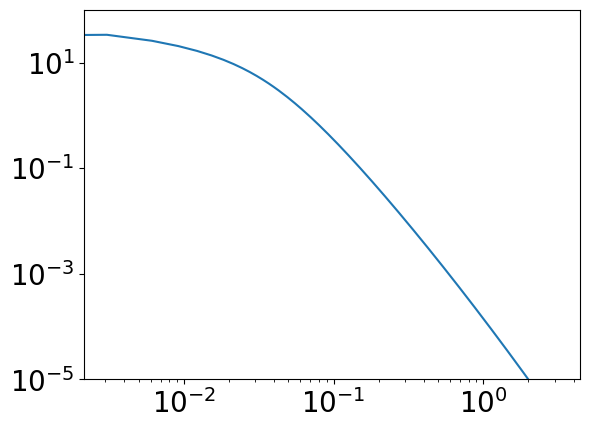

In [135]:
plt.loglog(k_arr, p1d_edr_fit[4])
plt.ylim(10e-6, 10e1)

Text(0.5, 1.0, '$P_{1D}$ from $\\xi_F$ fit')

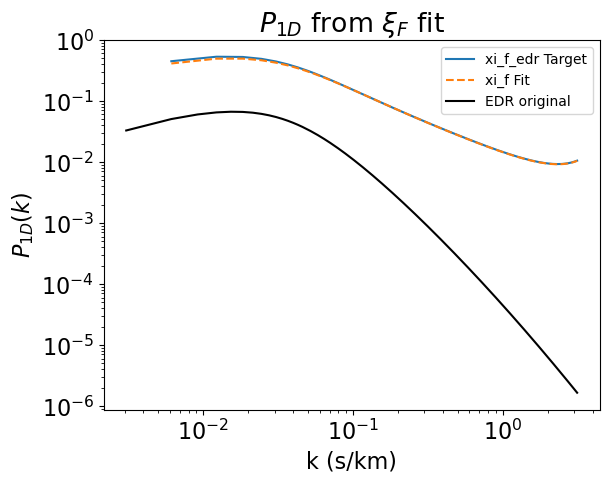

In [230]:

# NOTE: THIS WORKS!!! CHANGE BELOW

# # Convert back to P1D
# p1d_test = np.empty((zlist.size, k_arr.size))

# for i, z in enumerate(zlist):
#     # Reconstruct full correlation function with symmetry
#     xif_padded = np.concatenate((xif_edr_fit[i], np.zeros(numvpoints)))  # Pad second half with zeros
#     p1d_test[i] = np.fft.rfft(xif_padded) * (dv  / ( numvpoints))  # Proper normalization


################################

def compute_power_spectrum(xi_F, v_arr):
    # Ensure v_arr is evenly spaced
    dv = v_arr[1] - v_arr[0]

    if not np.allclose(np.diff(v_arr), dv):
        raise ValueError("Velocity array (v_arr) must be evenly spaced.")
    
    # Compute FFT of the correlation function
    fft_result = np.fft.rfft(xi_F)
    
    # Compute power spectrum (P(k)) without additional normalization by 2*pi or n
    power_spectrum = np.abs(fft_result)**2  * (dv) # / numvpoints)
    
    # Compute the corresponding wavenumbers (k)
    k_arr = 2 * np.pi * np.fft.rfftfreq(len(xi_F), d=dv) + 10e-12
    
    # Sort k and power spectrum for convenience
    k_sorted_indices = np.argsort(k_arr)
    k_arr = k_arr[k_sorted_indices]
    power_spectrum = power_spectrum[k_sorted_indices]
    
    return k_arr, power_spectrum


target_power = compute_power_spectrum(xi_f_target, v_array)
fit_power = compute_power_spectrum(fits[2][:], fits[6][:])

original_edr_power = p1d_edr_fit[4]

###################################

# plt.semilogx(k_arr[1:], p1d_edr_fit[4][1:], label='P1D EDR fit (original)')

# plt.loglog(target_power[0][1:], target_power[1][1:], label='xi_f_edr Target', color='tab:blue')
# plt.loglog(power_fit[0][1:], power_fit[1][1:], label='xi_f Fit', color='tab:orange', ls='--')

plt.loglog(target_power[0][1:], target_power[0][1:]*target_power[1][1:]/np.pi, label='xi_f_edr Target', color='tab:blue')
plt.loglog(fit_power[0][1:], fit_power[0][1:]*fit_power[1][1:]/np.pi, label='xi_f Fit', color='tab:orange', ls='--')

# plt.loglog(k_arr[1:], p1d_edr_fit[4][1:], label= 'EDR original')
plt.loglog(k_arr[1:], k_arr[1:]*p1d_edr_fit[4][1:]/np.pi, label='EDR original', color='black')


# plt.ylim(10e-6, 10e1)
# plt.xlim(10e-3, 10e-1)

plt.legend(fontsize=10, loc='upper right')
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}(k)$')
plt.title(r'$P_{1D}$ from $\xi_F$ fit')


In [200]:
10e3 / 10e-1

10000.0

In [195]:

# # # fit P1D of DESI EDR
# # # Start with an empty array the size / shape of k and z arrays
# # p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# # # Evaluate P1D for each (k,z), using DESI EDR Param. def. above
# # for i, z in enumerate(zlist):
# #     p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)


# ################################

# def compute_power_spectrum(xi_F, v_arr):
#     # Ensure v_arr is evenly spaced
#     dv = v_arr[1] - v_arr[0]

#     if not np.allclose(np.diff(v_arr), dv):
#         raise ValueError("Velocity array (v_arr) must be evenly spaced.")
    
#     # Compute FFT of the correlation function
#     fft_result = np.fft.rfft(xi_F) # note: missing normalization 
    
#     # Compute power spectrum (P(k)) without additional normalization by 2*pi or n
#     power_spectrum = np.abs(fft_result)**2 * (dv * numvpoints) 
    
#     # Compute the corresponding wavenumbers (k)
#     k_arr = 2 * np.pi * np.fft.rfftfreq(len(xi_F), d=dv)
    
#     # Sort k and power spectrum for convenience
#     k_sorted_indices = np.argsort(k_arr)
#     k_arr = k_arr[k_sorted_indices]
#     power_spectrum = power_spectrum[k_sorted_indices]
    
#     return k_arr, power_spectrum


# # test_power2 = compute_power_spectrum(fits[1][:], fits[6][:])
# edr_power = compute_power_spectrum(xi_f_target, v_array)

# power_fit = compute_power_spectrum(fits[2][:], fits[6][:])

# # original_edr_power = p1d_edr_fit[4]

# ###################################

# plt.loglog(k_arr[1:], k_arr[1:] * p1d_edr_fit[4][1:] / np.pi, label='P1D EDR fit (original)', color= 'black', lw='2')
# # plt.loglog(k_arr[1:], p1d_edr_fit[4][1:], label='P1D EDR fit (original)', color= 'black', lw='2')

# plt.loglog(edr_power[0][1:], edr_power[0][1:]* edr_power[1][1:] / np.pi, label='P1D from xi_f_edr', color='tab:blue')
# plt.loglog(power_fit[0][1:], power_fit[0][1:] * power_fit[1][1:] / np.pi, label='P1D from xi_f fit', ls='--', color = 'tab:orange')


# plt.legend(fontsize=10, loc='upper right')
# plt.xlabel('k (s/km)')
# plt.ylabel(r'k $P_{1D}(k) / \pi$')
# plt.title(r'$P_{1D}$ from $\xi_F$ fit')


In [108]:
# # get power from xi_f

# xi_F_values_edr = fits[1][:]
# xi_F_values_fit = fits[2][:]

# # assuming xi_F(v) is the correlation function in velocity space
# # and v is the velocity array (note: dv = 10 km/s)
# v = v_array[:len(xi_F_values_edr)]  # Velocity grid (matching the length of xi_F)

# # perform FFT of the correlation function
# fft_xi_F_edr = np.fft.fft(xi_F_values_edr)
# fft_xi_F_fit = np.fft.fft(xi_F_values_fit)

# # Power spectrum proportional to magnitude quared of FFT
# P_k_edr = np.abs(fft_xi_F_edr)**2
# P_k_fit = np.abs(fft_xi_F_fit)**2

# # compute the corresponding wavenumbers k (1d space, k conjugate to v)
# k = np.fft.fftfreq(len(P_k_edr), d = dv) * 2 * np.pi # convert to physical wavenumbers

# plt.figure(figsize=(6, 4))
# plt.rcParams.update({'font.size': 20})

# max_slice = 1000
# min_slice = 0

# # Plot the 1D power spectrum
# plt.semilogx(k[min_slice:max_slice], P_k_edr[min_slice:max_slice], label='EDR @ z = '+str(zlist[4]), color='tab:blue', lw=2)
# plt.semilogx(k[min_slice:max_slice], P_k_fit[min_slice:max_slice], label = 'Fit', color='tab:orange', lw=2, ls='--')
# plt.semilogx(k_arr, p1d_edr_fit[4], label = 'EDR P1D', color = 'black', lw=2) 
# # plt.xlabel('Wavenumber k')
# plt.xlabel('k (s/km)')
# plt.ylabel(r'$P_{1D}(k)$')
# plt.legend(fontsize=16, loc='lower left')
# # plt.xlim(right=10e-1)
# plt.title(r'$P_{1D}$ from $\xi_F$ fit')

# # plt.errorbar(k_arr[w], p1d_edr_fit|[4, w], e, label='EDR at: z = ' + str(zlist[4]), alpha = 1)

# plt.show()

In [79]:
len(P_k_edr)

513

## etc 

Try to get power from $\xi_F$

In [32]:

def compute_power_spectrum(xi_F, v_arr):
    # Ensure v_arr is evenly spaced
    dv = v_arr[1] - v_arr[0]
    if not np.allclose(np.diff(v_arr), dv):
        raise ValueError("Velocity array (v_arr) must be evenly spaced.")
    
    # Number of points
    n = len(xi_F)
    
    # Compute FFT of the correlation function
    fft_result = np.fft.fft(xi_F)
    
    # Compute power spectrum (P(k)) as the square of the Fourier transform magnitude
    power_spectrum = np.abs(fft_result)**2 * dv / (2 * np.pi)
    
    # Compute the corresponding wavenumbers (k)
    k_arr = 2 * np.pi * np.fft.fftfreq(n, d=dv)
    
    # Sort k and power spectrum for convenience
    k_sorted_indices = np.argsort(k_arr)
    k_arr = k_arr[k_sorted_indices]
    power_spectrum = power_spectrum[k_sorted_indices]
    
    return k_arr, power_spectrum


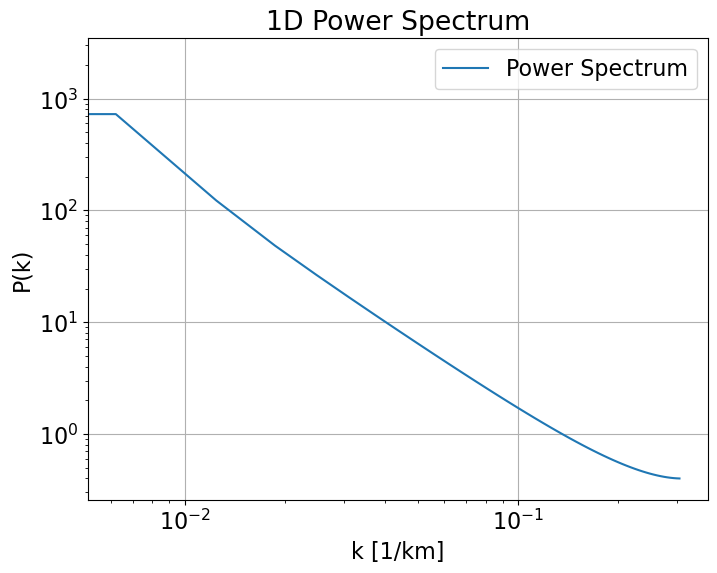

In [37]:
# Example 
# xi_F: Example correlation function values
# v_arr: Corresponding velocity array (e.g., evenly spaced in km/s)

xi_F = np.exp(-np.linspace(0, 100, 100)**2 / (2 * 30**2))  # Example Gaussian
v_arr = np.linspace(0, 1000, 100)  # Evenly spaced velocities in km/s


# xi_F = xi_f_optimized
# v_arr = v_array


k_arr, P_k = compute_power_spectrum(xi_F, v_arr)

# Plot the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.loglog(k_arr, P_k, label="Power Spectrum")
plt.xlabel("k [1/km]")
plt.ylabel("P(k)")
plt.title("1D Power Spectrum")
plt.legend()
plt.grid()
plt.show()


In [42]:
# set p1d precision
p1d_precision = 1e-1
# w = (k_arr > 1e-3) & (k_arr < 0.05)

# set p1d true
ptrue = p1d_edr_fit[:].ravel()

# set p1d true error, using precision above
e_p1d = p1d_precision * ptrue + 1e-8

# e = e_p1d.reshape(zlist.size, w.sum())[4] * k_arr
plt.errorbar(k_arr, p1d_edr_fit[4] * k_arr / np.pi, e_p1d, label='EDR at: z = ' + str(z))
plt.legend()

ValueError: operands could not be broadcast together with shapes (1025,) (100,) 

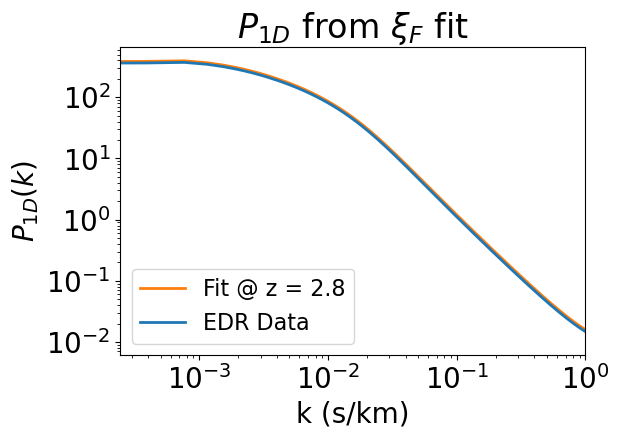

In [234]:
# get power from xi_f

xi_F_values = xi_f_optimized
xi_F_values_data = xif_edr_fit[redshift_index]

# assuming xi_F(v) is the correlation function in velocity space
# and v is the velocity array (note: dv = 1 km/s)
v = v_array[:len(xi_F_values)]  # Velocity grid (matching the length of xi_F)

# perform FFT of the correlation function
fft_xi_F = np.fft.fft(xi_F_values)
fft_xi_F_data = np.fft.fft(xi_F_values_data)

# Power spectrum proportional to magnitude quared of FFT
P_k = np.abs(fft_xi_F)**2
P_k_data = np.abs(fft_xi_F_data)**2

# compute the corresponding wavenumbers k (1d space, k conjugate to v)
k = np.fft.fftfreq(len(P_k), d = dv) * 2 * np.pi # convert to physical wavenumbers


plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 20})

# Plot the 1D power spectrum
plt.loglog(k_arr[:len(P_k)], P_k, label='Fit @ z = '+str(zlist[redshift_index]), color='tab:orange', lw=2)
plt.loglog(k_arr[:len(P_k)], P_k_data, label = 'EDR Data', color='tab:blue', lw=2)
# plt.xlabel('Wavenumber k')
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}(k)$')
plt.legend(fontsize=16, loc='lower left')
plt.xlim(right=10e-1)
plt.title(r'$P_{1D}$ from $\xi_F$ fit')
plt.show()

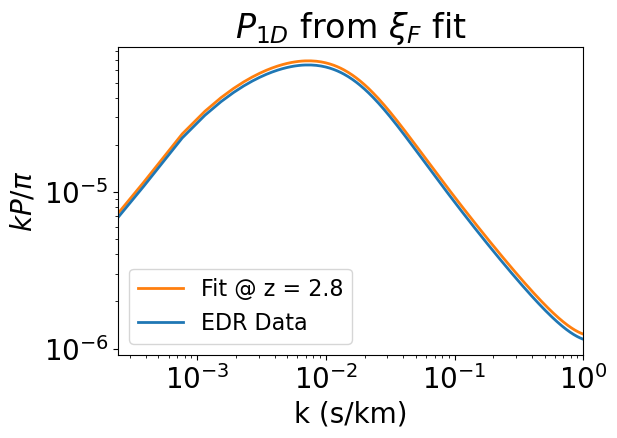

In [228]:
# normalize  1D power spectrum
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 20})

plt.loglog(k_arr[:len(P_k)], P_k * k / np.pi, label='Fit @ z = '+str(zlist[redshift_index]), color = 'tab:orange', lw=2)
plt.plot(k_arr[:len(P_k)], P_k_data * k / np.pi, label='EDR Data', color = 'tab:blue', lw=2)
plt.xlabel('k (s/km)')
plt.ylabel(r'$k P / \pi$')
plt.xlim(right=10e-1)
plt.legend(fontsize=16, loc='lower left')
plt.title(r'$P_{1D}$ from $\xi_F$ fit')
plt.show()

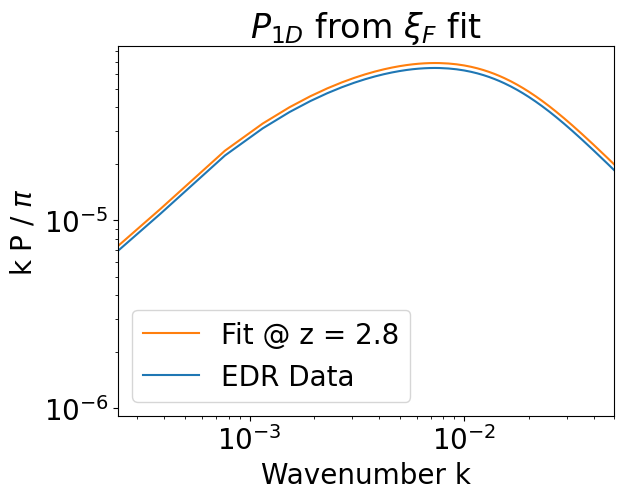

In [231]:
# normalize  1D power spectrum
plt.loglog(k_arr[:len(P_k)], P_k * k / np.pi, label='Fit @ z = '+str(zlist[redshift_index]), color = 'tab:orange')
plt.plot(k_arr[:len(P_k)], P_k_data * k / np.pi, label='EDR Data', color = 'tab:blue')
plt.xlabel('Wavenumber k')
plt.ylabel(r'k P / $\pi$')
# plt.xlim(right=5e-2)
# plt.ylim([5e-2, 2e-0])
plt.legend()
plt.title(r'$P_{1D}$ from $\xi_F$ fit')
plt.show()

In [ ]:
# try with error bars for EDR data?
# not actaully a good fit?

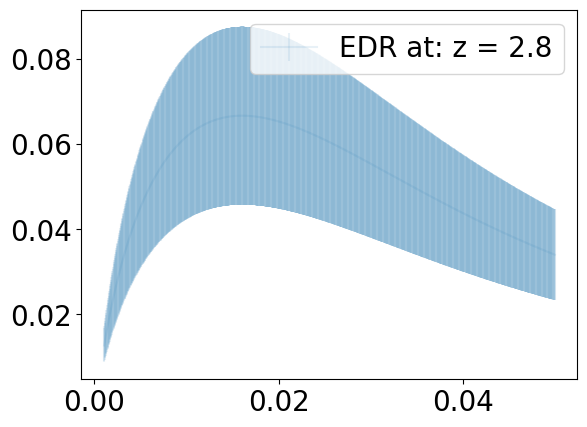

In [203]:
# set p1d precision
p1d_precision = 1e-1
w = (k_arr > 1e-3) & (k_arr < 0.05)

# set p1d true
ptrue = p1d_edr_fit[:, w].ravel()

# set p1d true error, using precision above
e_p1d = p1d_precision * ptrue + 1e-8

e = e_p1d.reshape(zlist.size, w.sum())[4] * k_arr[w]
plt.errorbar(k_arr[w], p1d_edr_fit[4, w] * k_arr[w] / np.pi, e, label='EDR at: z = ' + str(zlist[4]), alpha = 0.1)
plt.legend()

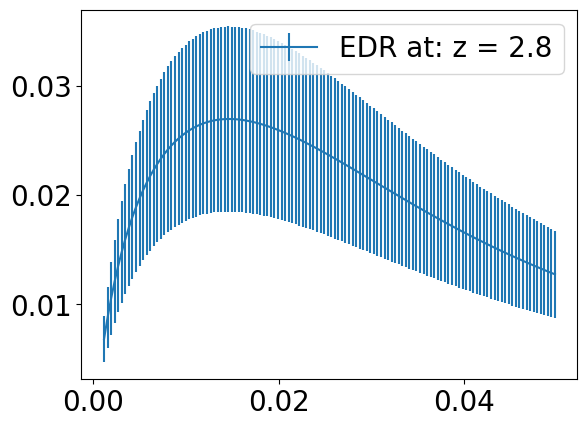

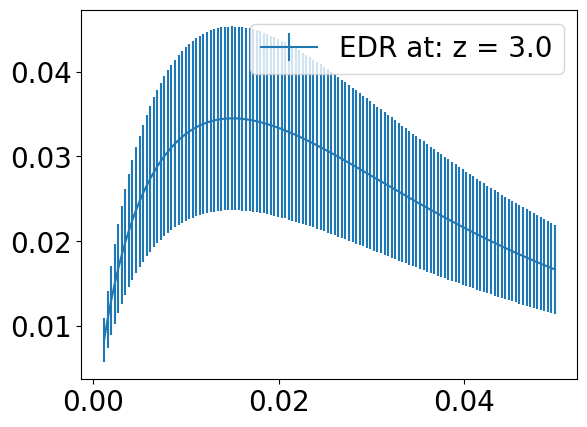

In [237]:
for i, z in enumerate([2.8,3.0]):
    e = e_p1d.reshape(zlist.size, w.sum())[i] * k_arr[w]
    plt.errorbar(k_arr[w], p1d_edr_fit[i, w] * k_arr[w] / np.pi, e, label='EDR at: z = ' + str(z))
    # plt.loglog(k_arr[:len(P_k)], (P_k * k_arr[:len(P_k)] / np.pi), label='fit', color = 'tab:orange')   
    # plt.xlim(right=10e-2)
    # plt.ylim([10e-3, 2e-0])
    plt.legend()
    plt.show()

## Asside / test

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f23c0f004c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

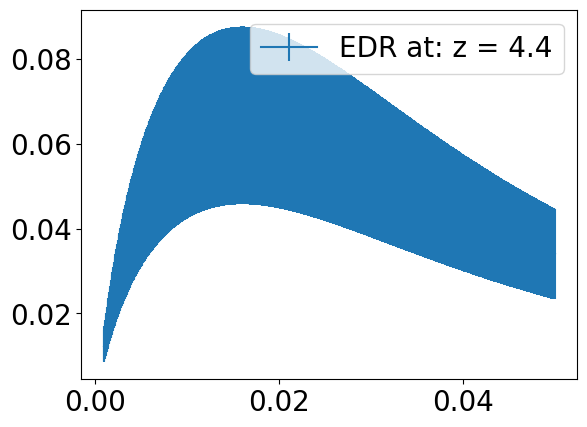

In [49]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')

# velocity array 
numvpoints = 2**16
dv = 1.0 # (km/s)
v_array = np.arange(numvpoints) * dv

# k-mode array
k_arr  = 2. * np.pi * np.fft.rfftfreq(2 * numvpoints, d=dv)

zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])
redshift_index = 4          # Index corresponding to z = 2.8
z = zlist[redshift_index]   # Redshift value (2.8)

# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

# set p1d precision
p1d_precision = 1e-1
w = (k_arr > 1e-3) & (k_arr < 0.05)

# set p1d true
ptrue = p1d_edr_fit[:, w].ravel()

# set p1d true error, using precision above
e_p1d = p1d_precision * ptrue + 1e-8
e = e_p1d.reshape(zlist.size, w.sum())[redshift_index] * k_arr[w]

plt.errorbar(k_arr[w], p1d_edr_fit[4, w] * k_arr[w] / np.pi, e, label='EDR at: z = ' + str(z))
plt.legend()

########################################################

# lognormal xi_f from xi_g, deals with scalars, not vectors
def lognXiFfromXiG_scalar(z, xi_gauss, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    sigma2 = 1.50381
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine])

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return a single xi_f scalar
    xi_f = np.sum(tempfunc) / np.pi

    return xi_f

########################################################################

# get xi_f target from desi edr p1d fit above
xif_edr_fit = np.empty((zlist.size, numvpoints))
for i, z in enumerate(zlist):
    xif_edr_fit[i] = np.fft.irfft(p1d_edr_fit[i])[:numvpoints] / dv
    
########################################################################

# create an Objective function for fsolve
def objective(xi_g, z, xi_f_target):
    xi_f_calculated = np.array([lognXiFfromXiG_scalar(z, xi_g_i) for xi_g_i in xi_g])
    return xi_f_calculated - xi_f_target

# # objective function with error weighting
# def weighted_objective(xi_g, z, xi_f_target, errors):
#     xi_f_calculated = np.array([lognXiFfromXiG_scalar(z, xi_g_i) for xi_g_i in xi_g])
#     residuals = (xi_f_calculated - xi_f_target) / errors
#     return np.sum(residuals**2)  # Weighted least squares

########################################################################

# Set parameters for optimization
xi_f_target = xif_edr_fit[redshift_index]  # Target xi_f array for z = 2.8

# Initial guess for xi_g as a 1D array matching the length of xi_f_target
xi_g_initial_guess = np.full_like(xi_f_target, fill_value=0.2)

# Optimize xi_g to match xi_f_target
xi_g_optimized = fsolve(objective, xi_g_initial_guess, args=(z, xi_f_target))

# from bestfit xi_g, get corresponding bestfit xi_f
def lognXiFfromXiG_array(xi_gauss, z, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    sigma2 = xi_gauss[0]
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).T

    # Weighted vector computation
    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return xi_f array
    xi_f = np.sum(tempfunc, axis=(1, 2)) / np.pi
    return xi_f

xi_f_optimized = lognXiFfromXiG(xi_gauss = xi_g_optimized, z = 2.8,
                                tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3)

######################################################

# get 1D power from xi_f

xi_F_values = xi_f_optimized
xi_F_values_data = xif_edr_fit[redshift_index]

# Need to: Plot bestfit p1d from xi_f_optimized, and plot against p1d and errorbars from edr data




In [333]:
# Compute P1D from xi_F (Fourier Transform relationship)
# def compute_p1d_from_xi_f(xi_f, dv, numvpoints):
#     xi_f_extended = np.zeros(2 * numvpoints)  # Ensure padding for FFT
#     xi_f_extended[:numvpoints] = xi_f  # Fill in the xi_f values
#     p1d = np.fft.rfft(xi_f_extended) * dv  # Fourier transform with spacing dv
#     return np.abs(p1d)**2  # Return power spectrum

def compute_p1d_from_xi_f(xi_f, dv, numvpoints):
    p1d = np.fft.rfft(xi_f_optimized)
    return np.abs(p1d)**2  # Return power spectrum

# Compute optimized P1D
p1d_optimized = compute_p1d_from_xi_f(xi_f_optimized, dv, numvpoints)


In [334]:
p1d_optimized_slice = p1d_optimized[1:len(p1d_optimized)]
k_arr_slice = k_arr[1:len(k_arr)]

In [48]:
# Plot the comparison
plt.figure(figsize=(8, 6))

# Optimized P1D
plt.loglog(k_arr_slice[w[1:len(w)]], p1d_optimized_slice[:k_arr_slice[w[1:len(w)]].size] * k_arr_slice[w[1:len(w)]] / np.pi, 
           label='Optimized P1D', lw=2, color='tab:orange')

# EDR P1D with error bars
plt.errorbar(k_arr[w], p1d_edr_fit[redshift_index, w] * k_arr[w] / np.pi, 
             e, fmt='o', label='EDR P1D', alpha=0.7, capsize=4, color = 'tab:blue')



# Labels and legend
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'k $P_{1D}(k) / \pi$', fontsize=14)
plt.title(f'Optimized vs EDR P1D at z = '+str(zlist[redshift_index]), fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

NameError: name 'k_arr_slice' is not defined

<Figure size 800x600 with 0 Axes>

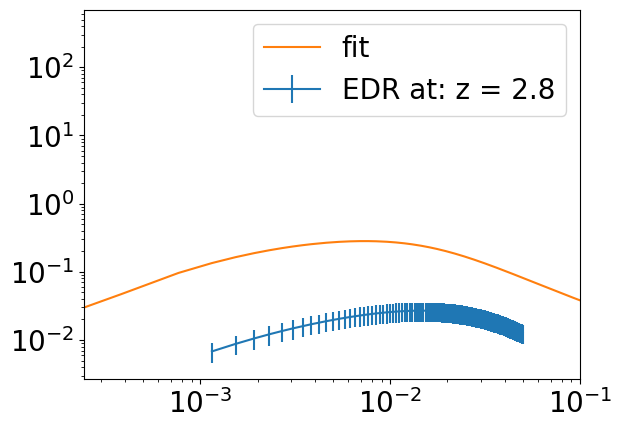

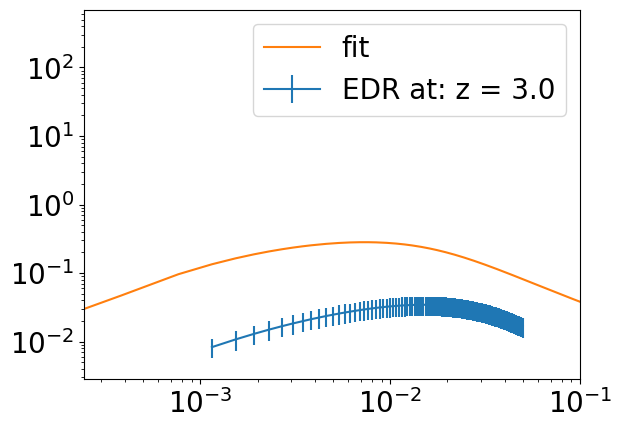

In [223]:
# set p1d precision
p1d_precision = 1e-1
w = (k_arr > 1e-3) & (k_arr < 0.05)

# set p1d true
ptrue = p1d_edr_fit[:, w].ravel()

# set p1d true error, using precision above
e_p1d = p1d_precision * ptrue + 1e-8

for i, z in enumerate([2.8,3.0]):
    e = e_p1d.reshape(zlist.size, w.sum())[i] * k_arr[w]
    plt.errorbar(k_arr[w], p1d_edr_fit[i, w]*k_arr[w] / np.pi, e, label='EDR at: z = ' + str(z))
    plt.loglog(k_arr[:len(P_k)], (P_k)* k_arr[:len(P_k)] / np.pi, label='fit', color = 'tab:orange')   
    plt.xlim(right=10e-2)
    # plt.ylim([10e-3, 2e-0])
    plt.legend()
    plt.show()

### Logistic funtion test

In [ ]:
def logistic_function(x, L=1, k=1, x0=0):
    fx = L / (1 + np.e**(-k*(x - x0)))
    return(fx)

xlist = np.arange(-6,6,0.0001)
test_logistic = []

for i in xlist: 
    test_logistic.append((1 - logistic_function(i)) *1.4 )

# plt.plot(v_array, test_logistic)


#######################################################


def lognXiFfromXiG(xi_gauss, z, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: np.array(float)
        Array of xi_g values from Gaussian random field
    """
    sigma2 = xi_gauss[0]
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).T

    # Weighted vector computation
    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return xi_f array
    xi_f = np.sum(tempfunc, axis=(1, 2)) / np.pi
    return xi_f

######################################################

xi_f_logistic = lognXiFfromXiG(xi_gauss = test_logistic, z = 3,
                                tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3)

######################################################

plt.plot(xi_f_logistic, color='tab:blue', label= r'$\xi_F$')
plt.legend()
plt.title('Logistic function test')